# Previsão da temperatura horária da cidade de São João del-Rei utilizando modelos de Machine Learning

In [25]:
# install pkgs
# ! pip install scikit-learn
# ! pip install skforecast

In [26]:
# imports and settings
import math
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer   # necessario para o IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_error, max_error, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

In [27]:
# carrega os dados
df = pd.read_csv('https://raw.githubusercontent.com/srlucasromulo/PPGCC-DS-DeepLearning/main/data/sjdr_raw.csv', low_memory=False, sep=',') # github
# df = pd.read_csv('./data/sjdr_raw.csv', low_memory=False, sep=',') # local
df.data = df.data.apply(lambda x: datetime.date.fromisoformat(x))

In [28]:
df.sample(5)

,temperatura,data,hora
70946,19.9,2021-02-04,2
30676,12.9,2016-07-02,4
64211,11.0,2020-04-29,11
83693,12.1,2022-07-20,5
74477,10.6,2021-07-01,5


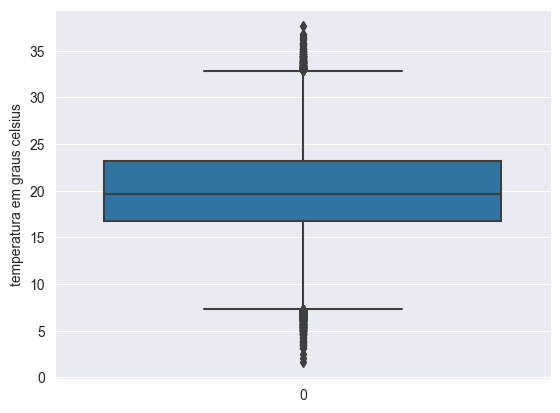

In [29]:
sns.boxplot(df.temperatura)
plt.ylabel('temperatura em graus celsius')
plt.show()

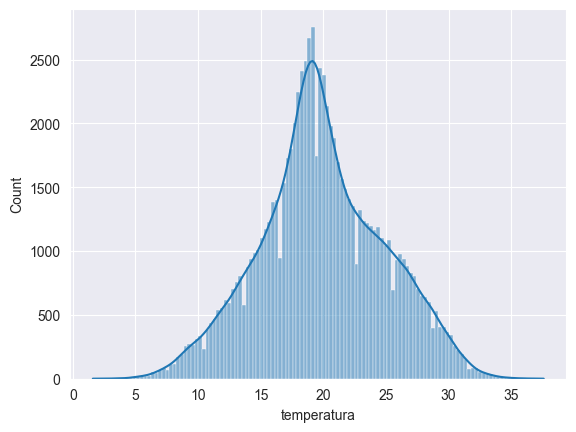

In [30]:
sns.histplot(df.temperatura, kde=True)
plt.show()

In [31]:
df.temperatura.describe()

count    83808.000000
mean        19.893916
std          4.972748
min          1.600000
25%         16.800000
50%         19.600000
75%         23.200000
max         37.600000
Name: temperatura, dtype: float64

### Dados faltantes

In [32]:
# % dados faltantes %
(df.temperatura.isna().sum() / len(df)) * 100

4.381161007667032

In [33]:
# separacao de dados da data
df['dia'] = df.data.apply(lambda x: int(x.day))
df['mes'] = df.data.apply(lambda x: int(x.month))
df['ano'] = df.data.apply(lambda x: int(x.year))

In [34]:
# estacao do ano
def get_season(d):
	if d < datetime.date(day=21, month=3, year=d.year): return 'verão'
	if datetime.date(day=21, month=3, year=d.year) <= d < datetime.date(day=21, month=6, year=d.year): return 'outono'
	if datetime.date(day=21, month=6, year=d.year) <= d < datetime.date(day=23, month=9, year=d.year): return'inverno'
	if datetime.date(day=23, month=9, year=d.year) <= d < datetime.date(day=21, month=12, year=d.year): return'primavera'
	if datetime.date(day=21, month=12, year=d.year) <= d: return'verão'
df['estacao'] = df.data.apply(lambda x: get_season(x))

In [35]:
# preenche dados faltantes (gear uma nova coluna para comparacao com dados originais)
imputer = IterativeImputer(random_state=0)
imputer.fit(df[['temperatura', 'dia', 'mes', 'ano', 'hora']])
result = imputer.transform(df[['temperatura', 'dia', 'mes', 'ano', 'hora']])
df['temperatura_gerada'] = result[:, 0]

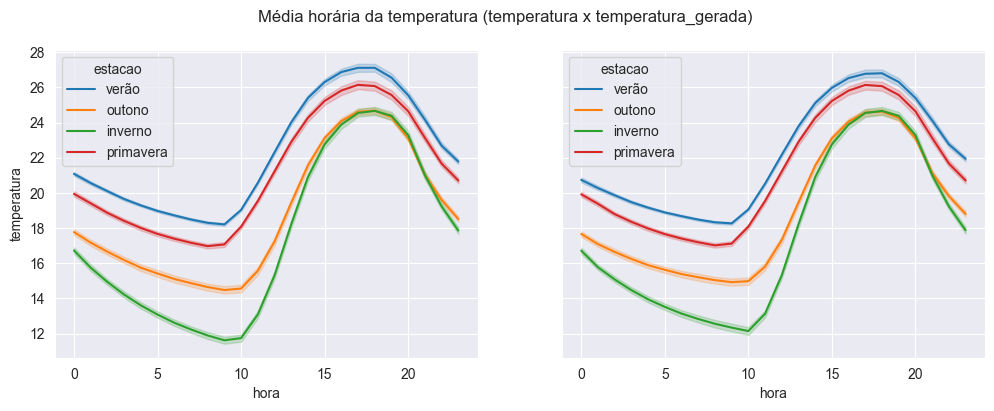

In [36]:
# compara dados originais com dados gerados pelo imputer
fig, ax = plt.subplots(ncols=2, sharey='all', figsize=(12, 4))
fig.suptitle('Média horária da temperatura (temperatura x temperatura_gerada)')

sns.lineplot(ax=ax[0], data=df, x='hora', y='temperatura', hue='estacao')
sns.lineplot(ax=ax[1], data=df, x='hora', y='temperatura_gerada', hue='estacao')

plt.show()

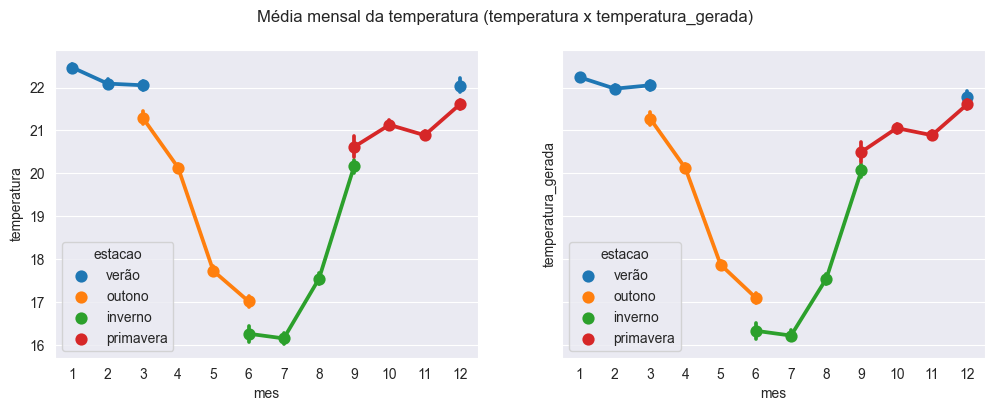

In [37]:
# temperatura media mensal / estacoes do ano - compara dados originais com dados gerados pelo imputer
fig, ax = plt.subplots(ncols=2, sharey='all', figsize=(12, 4))
fig.suptitle('Média mensal da temperatura (temperatura x temperatura_gerada)')

sns.pointplot(ax=ax[0], data=df, x='mes', y='temperatura', hue='estacao')
sns.pointplot(ax=ax[1], data=df, x='mes', y='temperatura_gerada', hue='estacao')

plt.show()

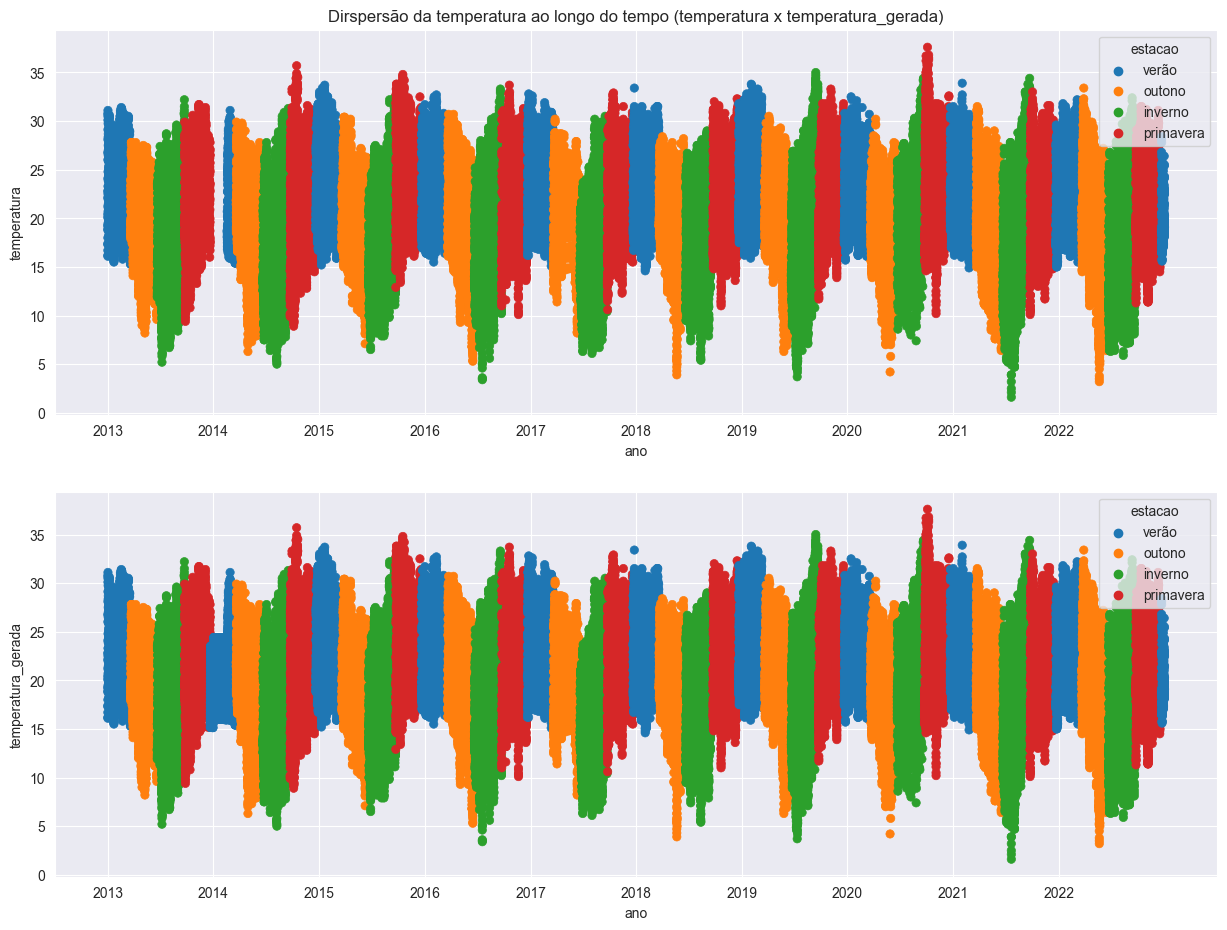

In [38]:
# plota timeline da temperatura
fig, ax = plt.subplots(nrows=2, figsize=(15, 11))
ax[0].set_title('Dirspersão da temperatura ao longo do tempo (temperatura x temperatura_gerada)')

x_ticks = df.loc[(df.dia==1) & (df.mes==1) & (df.hora==0)].index
x_labes = df.loc[x_ticks].ano

sns.scatterplot(ax=ax[0], data=df, x=df.index, y='temperatura', hue='estacao', markers='.', edgecolor=None)
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels(x_labes)
ax[0].set_xlabel('ano')

sns.scatterplot(ax=ax[1], data=df, x=df.index, y='temperatura_gerada', hue='estacao', markers='.', edgecolor=None)
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labes)
ax[1].set_xlabel('ano')

plt.show()

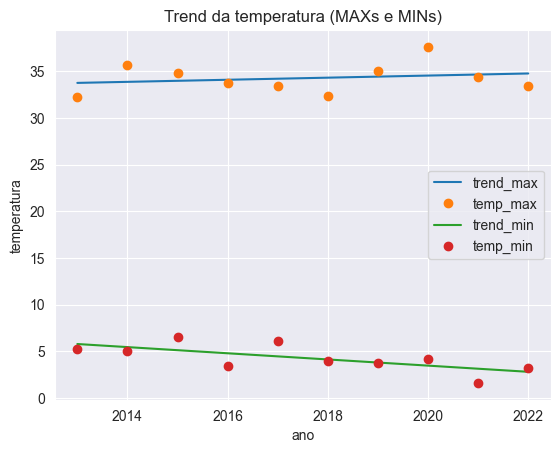

In [39]:
# trend temperatura maxs e mins
max_ano = df.groupby('ano')['temperatura'].max()
min_ano = df.groupby('ano')['temperatura'].min()

trend_max = np.poly1d(np.polyfit(x=max_ano.index, y=max_ano.values, deg=1))
trend_min = np.poly1d(np.polyfit(x=min_ano.index, y=min_ano.values, deg=1))

plt.plot(max_ano.index, trend_max(max_ano.index), label='trend_max')
plt.plot(max_ano.index, max_ano.values, marker='o', ls='', label='temp_max')

plt.plot(min_ano.index, trend_min(min_ano.index), label='trend_min')
plt.plot(min_ano.index, min_ano.values, marker='o', ls='', label='temp_min')

plt.title('Trend da temperatura (MAXs e MINs)')
plt.xlabel('ano')
plt.ylabel('temperatura')
plt.legend()
plt.show()

In [40]:
# salva df
df_train = df.drop(columns=['temperatura', 'data', 'estacao']).rename(columns={'temperatura_gerada': 'temperatura'}).reset_index(drop=True)
df_train.to_csv('./data/sjdr_train.csv', index=False)

## Machine Learning

In [41]:
# cria um index utilizando a data (forecast)
df_train = pd.read_csv(f'./data/sjdr_train.csv', low_memory=False, sep=',')
df_train['data'] = df_train.apply(
	lambda x: datetime.datetime(day=int(x.dia), month=int(x.mes), year=int(x.ano), hour=int(x.hora)), axis=1
)
df_train.set_index(df_train.data, inplace=True)

df_test = pd.read_csv(f'./data/sjdr_test.csv', low_memory=False, sep=',')
df_test['data'] = df_test.apply(
	lambda x: datetime.datetime(day=int(x.dia), month=int(x.mes), year=int(x.ano), hour=int(x.hora)), axis=1
)
df_test.set_index(df_test.data, inplace=True)

In [42]:
# GradientBoostingRegressor
y = df_train.temperatura
x = df_train[['dia', 'mes', 'ano', 'hora']]

reg = GradientBoostingRegressor(random_state=0)

k_fold = KFold(n_splits=10, shuffle=True, random_state=True)

param_grid = {
	'learning_rate': [.05],
}

tuner = GridSearchCV(
	estimator=reg, param_grid=param_grid, cv=k_fold,
	scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'max_error'], refit='neg_root_mean_squared_error',
)

gb_result = tuner.fit(x, y)

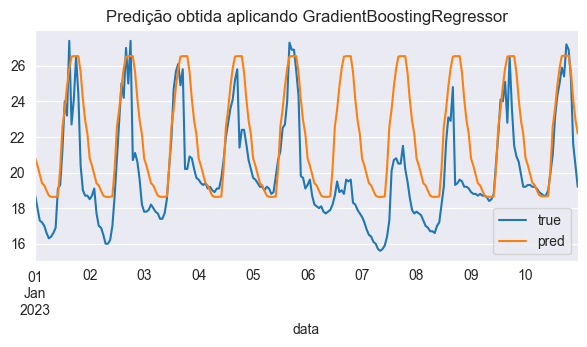

In [43]:
_, ax = plt.subplots(figsize=(7, 3))
plt.title('Predição obtida aplicando GradientBoostingRegressor')

y_true = df_test.temperatura
y_pred = pd.DataFrame(gb_result.best_estimator_.predict(df_test[['dia', 'mes', 'ano', 'hora']])).set_index(df_test.data)[0]

gb_errors = {
	'model': 'GradientBoosting',
	'mean_absolute_error': mean_absolute_error(y_true, y_pred),
	'max_error': max_error(y_true, y_pred),
	'RMSE': math.sqrt(mean_squared_error(y_true, y_pred)),
}

y_true.plot(ax=ax, label='true')
y_pred.plot(ax=ax, label='pred')

plt.legend()
plt.show()

In [44]:
# RandomForestRegressor
y = df_train.temperatura
x = df_train[['dia', 'mes', 'ano', 'hora']]

reg = RandomForestRegressor(random_state=0)

k_fold = KFold(n_splits=10, shuffle=True, random_state=True)

param_grid = {
	'n_estimators': [150],
	'criterion': ['friedman_mse'],
}

tuner = GridSearchCV(
	estimator=reg, param_grid=param_grid, cv=k_fold,
	scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'max_error'], refit='neg_root_mean_squared_error',
)

rf_result = tuner.fit(x, y)

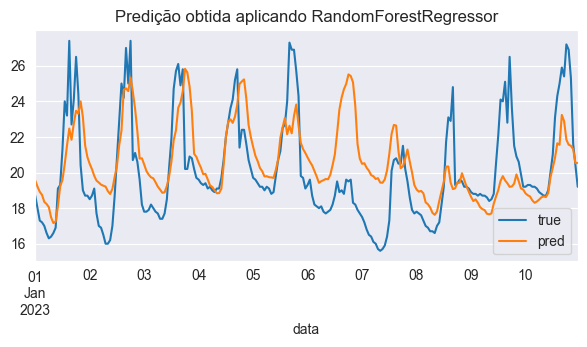

In [45]:
_, ax = plt.subplots(figsize=(7, 3))
plt.title('Predição obtida aplicando RandomForestRegressor')

y_true = df_test.temperatura
y_pred = pd.DataFrame(rf_result.best_estimator_.predict(df_test[['dia', 'mes', 'ano', 'hora']])).set_index(df_test.data)[0]

rf_errors = {
	'model': 'RandomForest',
	'mean_absolute_error': mean_absolute_error(y_true, y_pred),
	'max_error': max_error(y_true, y_pred),
	'RMSE': math.sqrt(mean_squared_error(y_true, y_pred)),
}

y_true.plot(ax=ax, label='true')
y_pred.plot(ax=ax, label='pred')

plt.legend()
plt.show()

In [46]:
# forecast
y_train = df_train.temperatura.asfreq('H')
y_test = df_test.temperatura.asfreq('H')

forecaster = ForecasterAutoreg(
	regressor=RandomForestRegressor(random_state=0, criterion='friedman_mse'),
	lags=20
)

metrics, predictions = backtesting_forecaster(
	forecaster=forecaster,
	y=pd.concat([y_train, y_test]),
	steps=15,
	metric='mean_squared_error',
	initial_train_size=len(y_train),
	fixed_train_size=False,
	show_progress=False,
)

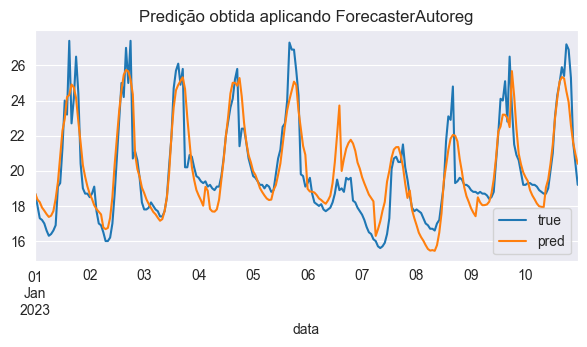

In [47]:
_, ax = plt.subplots(figsize=(7, 3))
plt.title('Predição obtida aplicando ForecasterAutoreg')

y_true = y_test
y_pred = predictions

fc_errors = {
	'model': 'Forecast',
	'mean_absolute_error': mean_absolute_error(y_true, y_pred),
	'max_error': max_error(y_true, y_pred),
	'RMSE': math.sqrt(mean_squared_error(y_true, y_pred)),
}

y_true.plot(ax=ax, label='true')
y_pred.plot(ax=ax, label='pred')

plt.legend()
plt.show()

In [48]:
# comparação dos modelos
pd.DataFrame(data=[gb_errors, rf_errors, fc_errors])

,model,mean_absolute_error,max_error,RMSE
0,GradientBoosting,2.198198,7.713930,2.887426
1,RandomForest,1.896953,7.305333,2.427012
2,Forecast,1.037904,4.816000,1.369398
